In [415]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [416]:
cur_fp = './data/single_df.csv'
df = pd.read_csv(cur_fp).to_dict()
for i, j in df.items():
    if isinstance(j, dict):
        df[i] = [k for _,k in j.items()]

## 第一问: 对momentum定量
momentum = (后5次的胜利数(包括本次) + 前5次胜利场数)/10 + 发球优势\*0.067 + 胜利盘数*0.3

In [417]:
# 动量
def momentum_true(df, player:int):
    res = []
    player_score = df['point_victor']
    n = len(player_score)
    for i in range(n):
        cur_momentum = sum([j==player for j in player_score[i-5:i+5]]) / 10
        if df['server'] == player:
           cur_momentum += 0.067
        cur_momentum += df['p{}_sets'.format(player)][i] * 0.3
        res.append(cur_momentum)
    return res

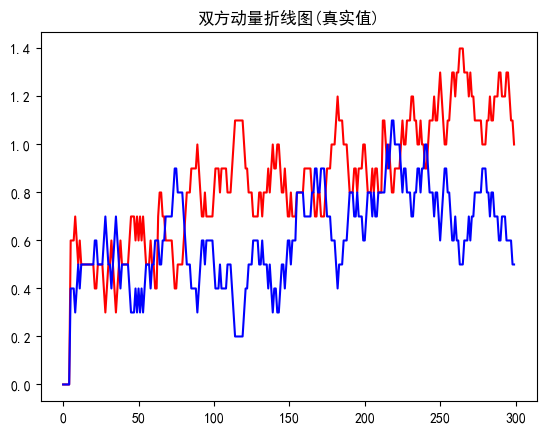

In [418]:
p1_momentum = momentum_true(df, 1)
p2_momentum = momentum_true(df, 2)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title('双方动量折线图(真实值)')
plt.plot(p1_momentum, color='red')
plt.plot(p2_momentum, color='blue')

In [419]:
# 先平滑, 加入arima
from scipy.signal import savgol_filter
from statsmodels.tsa.arima.model import ARIMA

def arima_predict(player:int,end=-1):
    window_size = 5  # 窗口大小
    poly_order = 2  # 多项式拟合阶数
    p_points = savgol_filter(df['p{}_points_won'.format(player)], window_size, poly_order)
    model = ARIMA(endog=p_points, order=(2,1,2))
    model_fit = model.fit()
    end = len(p_points)-1 if end == -1 else end
    predictions = list(model_fit.predict(start=0,end=end))
    return predictions

In [420]:
# 近似的动量
def momentum(df, player:int):
    res = []
    player_score = df['point_victor']
    player_score_prediction = arima_predict(player)
    n = len(player_score)
    for i in range(n):
        cur_momentum = sum([j==player for j in player_score[i-5:i]+player_score_prediction[i:i+5]]) / 10 + 0.2 # 修正因子
        if df['server'] == player:
           cur_momentum += 0.067
        cur_momentum += df['p{}_sets'.format(player)][i] * 0.3
        res.append(cur_momentum)
    return res

c:\Users\Lithium\OneDrive\桌面\preMCM\.env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Lithium\OneDrive\桌面\preMCM\.env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


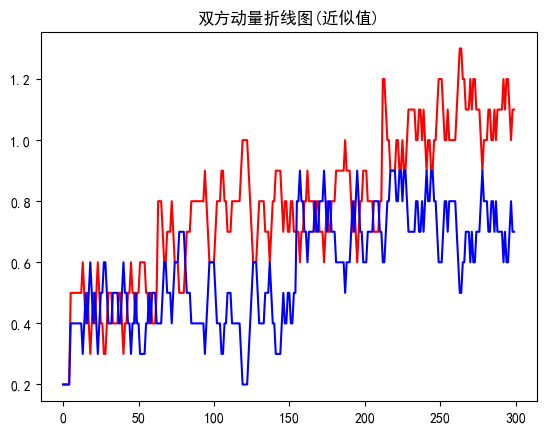

In [421]:
p1_momentum = momentum(df, 1)
p2_momentum = momentum(df, 2)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title('双方动量折线图(近似值)')
plt.plot(p1_momentum, color='red')
plt.plot(p2_momentum, color='blue')

## 第三题: 开发模型预测什么迹象表明比赛开始对某方有利
分类, 比分 **快速** 接近并 **反超** 的地方就是转折点

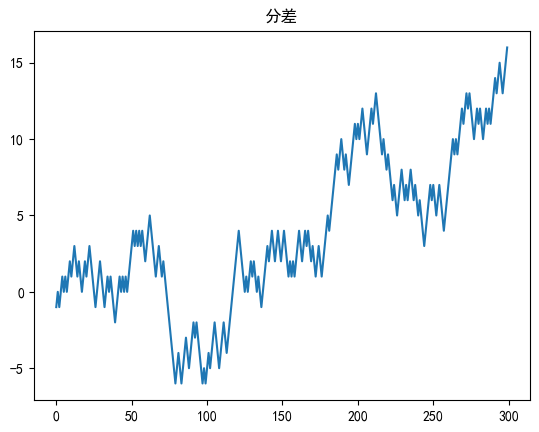

In [422]:
# 分差可视化
from itertools import pairwise
score_dif = np.array(df['p1_points_won']) - np.array(df['p2_points_won'])
score_dif = score_dif.tolist()

discard_score_dif = score_dif   # 备用, 离散值
discard_derive_score_dif = [0]+[i-j for i,j in pairwise(discard_score_dif)]# 备用, 离散值

plt.title("分差")
plt.plot(score_dif)

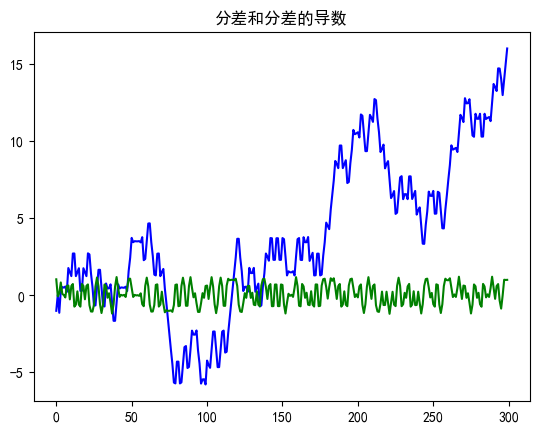

In [423]:
# 平滑分差
from numpy import gradient
from collections import Counter
turning_points = []
window_size = 10  # 窗口大小
poly_order = 8  # 多项式拟合阶数
score_dif = savgol_filter(score_dif, window_size, poly_order)
derive_of_score_dif = gradient(score_dif)
        
plt.title("分差和分差的导数")
plt.plot(score_dif, color='blue')
plt.plot(derive_of_score_dif, color='green')

0.0600789798437704 0.07877124518306663 0.6868794576757453 0.828781912010479
1.205062866210456


(array([ 3.,  8.,  6.,  2.,  0.,  1.,  0.,  0., 18.,  9., 28., 12.,  8.,
         3.,  0.,  0.,  1.,  2.,  7.,  8., 13.,  1.,  5.,  6.,  4.,  8.,
         5.,  5.,  5.,  0.,  0.,  0.,  5., 13., 18., 25.,  7., 18.,  0.,
         1.,  0.,  1.,  5.,  9.,  9.,  7.,  6.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.]),
 array([-1.15, -1.1 , -1.05, -1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75,
        -0.7 , -0.65, -0.6 , -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 ,
        -0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,
         0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,
         0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95,  1.  ,  1.05,
         1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,  1.5 ,
         1.55]),
 <BarContainer object of 54 artists>)

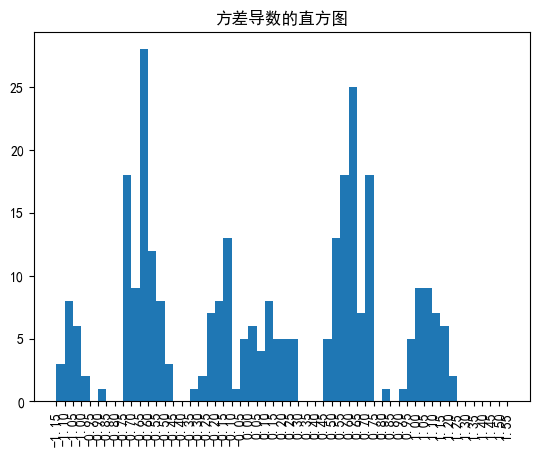

In [424]:
# 确定导数阈值: +-0.75 或者 分差0附近且+-0.5
print(derive_of_score_dif.mean(), np.median(derive_of_score_dif), np.std(derive_of_score_dif), np.sqrt(np.std(derive_of_score_dif)))
print(max(derive_of_score_dif))
x = [i*0.05 for i in range(-int(1.2/0.05), int(1.6/0.05))]
plt.title("方差导数的直方图")
plt.xticks(x, rotation=90)
plt.hist(derive_of_score_dif, bins=x)

(array([ 8., 12., 10., 10.,  6., 10., 32., 35., 29., 27.,  9., 11., 19.,
         9., 11., 13., 13., 19.,  8.,  3.,  5.]),
 array([-6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,
         7.,  8.,  9., 10., 11., 12., 13., 14., 15.]),
 <BarContainer object of 21 artists>)

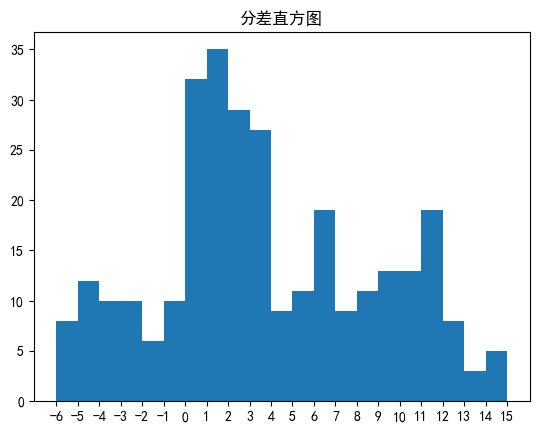

In [425]:
# 确定分差0附近是什么意思: -1, 0, +1
x = [i for i in range(-6,16)]
plt.title("分差直方图")
plt.xticks(x)
plt.hist(score_dif, bins=x)

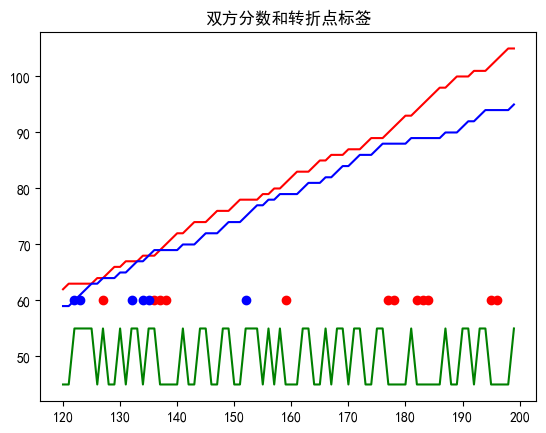

In [426]:
# 标签 Y 
n = len(score_dif)
Y = [0]*n
for i in range(n):
    if abs(derive_of_score_dif[i])>=0.75 or abs(score_dif[i])<=1 and abs(derive_of_score_dif[i])>=0.55:
        if derive_of_score_dif[i]>0:
            Y[i] = 1
        else:
            Y[i] = 2

# 查看be区间
b, e = 120, 200
up_line, base_line = 60, 50
x = list(range(b,e))

# p1-p2优势区 离散图
## 离散图y
p1_Y, p2_Y = [], []
for i in Y:
    if i == 0:
        p1_Y.append(0)
        p2_Y.append(0)
    elif i == 1:
        p1_Y.append(up_line)
        p2_Y.append(0)
    else:
        p2_Y.append(up_line)
        p1_Y.append(0)
## 离散图x
p1_scatter_x = []
p2_scatter_x = []
for i in x:
    if p1_Y[i]>0:
        p1_scatter_x.append(i)
    if p2_Y[i]>0:
        p2_scatter_x.append(i)
p1_Y, p2_Y = [up_line]*len(p1_scatter_x), [up_line]*len(p2_scatter_x)
plt.title("双方分数和转折点标签")
plt.plot(x,df['p1_points_won'][b:e],color='red')
plt.plot(x,df['p2_points_won'][b:e],color='blue')
plt.plot(x,[i*5+base_line for i in discard_derive_score_dif[b:e]],color='green')
plt.scatter(p1_scatter_x,p1_Y, color='red')
plt.scatter(p2_scatter_x,p2_Y, color='blue')

#### 定义完转折点, 用xgboost

In [427]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from pandas import read_csv
import numpy as np
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn import metrics
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from xgboost import XGBClassifier, plot_importance
import warnings
import seaborn as sns

In [428]:
# 标签: Y [0(波动),1(对p1有利),2(对p2有利)]
# features: 已有标签, single_df和2024c\traintestds\2023-wimbledon-1301融合, 手工去掉一些特征, 得到all_int文件

dataset = pd.read_csv('data/single_df_all_int.csv')
dataset.drop(['p1_win_possiblity','p2_win_possiblity'],axis=1, inplace=True) # 看着俩就是作弊了
# 加入动量! 
dataset['p1_momentum'] = p1_momentum
dataset['p2_momentum'] = p2_momentum
dataset.head(10)

,p1_sets,p2_sets,p1_games,p2_games,server,serve_no,point_victor,game_victor,set_victor,p1_ace,...,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,rally_count,score_dif_p1,score_dif_p2,p1_comble,p2_comble,p1_momentum,p2_momentum
0,0,0,0,0,1,2,2,0,0,0,...,0,0,0,2,-0.224182,0.224182,-0.416655,-0.406081,0.2,0.2
1,0,0,0,0,1,1,1,0,0,0,...,0,0,0,1,-0.119727,0.119727,-0.416655,-0.406081,0.2,0.2
2,0,0,0,0,1,1,2,0,0,0,...,0,0,0,4,-0.224182,0.224182,-0.416655,-0.406081,0.2,0.2
3,0,0,0,0,1,1,1,0,0,0,...,0,0,0,13,-0.119727,0.119727,-0.416655,-0.406081,0.2,0.2
4,0,0,0,0,1,1,1,0,0,1,...,0,0,0,1,-0.015272,0.015272,-0.416655,-0.406081,0.2,0.2
5,0,0,0,0,1,2,2,0,0,0,...,0,0,0,2,-0.119727,0.119727,1.440699,-0.406081,0.5,0.4
6,0,0,0,0,1,1,1,0,0,1,...,0,0,0,1,-0.015272,0.015272,-0.416655,-0.406081,0.5,0.4
7,0,0,0,0,1,2,2,0,0,0,...,0,0,0,6,-0.119727,0.119727,-0.416655,-0.406081,0.5,0.4
8,0,0,0,0,1,1,1,0,0,0,...,0,0,0,7,-0.015272,0.015272,-0.416655,-0.406081,0.5,0.4
9,0,0,0,0,1,1,1,1,0,0,...,0,0,0,5,0.089183,-0.089183,-0.416655,-0.406081,0.5,0.4


In [429]:
# 热力图
heatdf = pd.read_csv('data/single_df_all_int.csv')
heatdf['Y'] = Y
heatdf['p1_momentum'] = p1_momentum
heatdf['p2_momentum'] = p2_momentum
heatdf.head()

,p1_sets,p2_sets,p1_games,p2_games,server,serve_no,point_victor,game_victor,set_victor,p1_ace,...,rally_count,score_dif_p1,score_dif_p2,p1_comble,p2_comble,p1_win_possiblity,p2_win_possiblity,Y,p1_momentum,p2_momentum
0,0,0,0,0,1,2,2,0,0,0,...,2,-0.224182,0.224182,-0.416655,-0.406081,3,2,1,0.2,0.2
1,0,0,0,0,1,1,1,0,0,0,...,1,-0.119727,0.119727,-0.416655,-0.406081,3,2,0,0.2,0.2
2,0,0,0,0,1,1,2,0,0,0,...,4,-0.224182,0.224182,-0.416655,-0.406081,3,2,0,0.2,0.2
3,0,0,0,0,1,1,1,0,0,0,...,13,-0.119727,0.119727,-0.416655,-0.406081,3,2,1,0.2,0.2
4,0,0,0,0,1,1,1,0,0,1,...,1,-0.015272,0.015272,-0.416655,-0.406081,3,2,0,0.2,0.2


<Axes: >

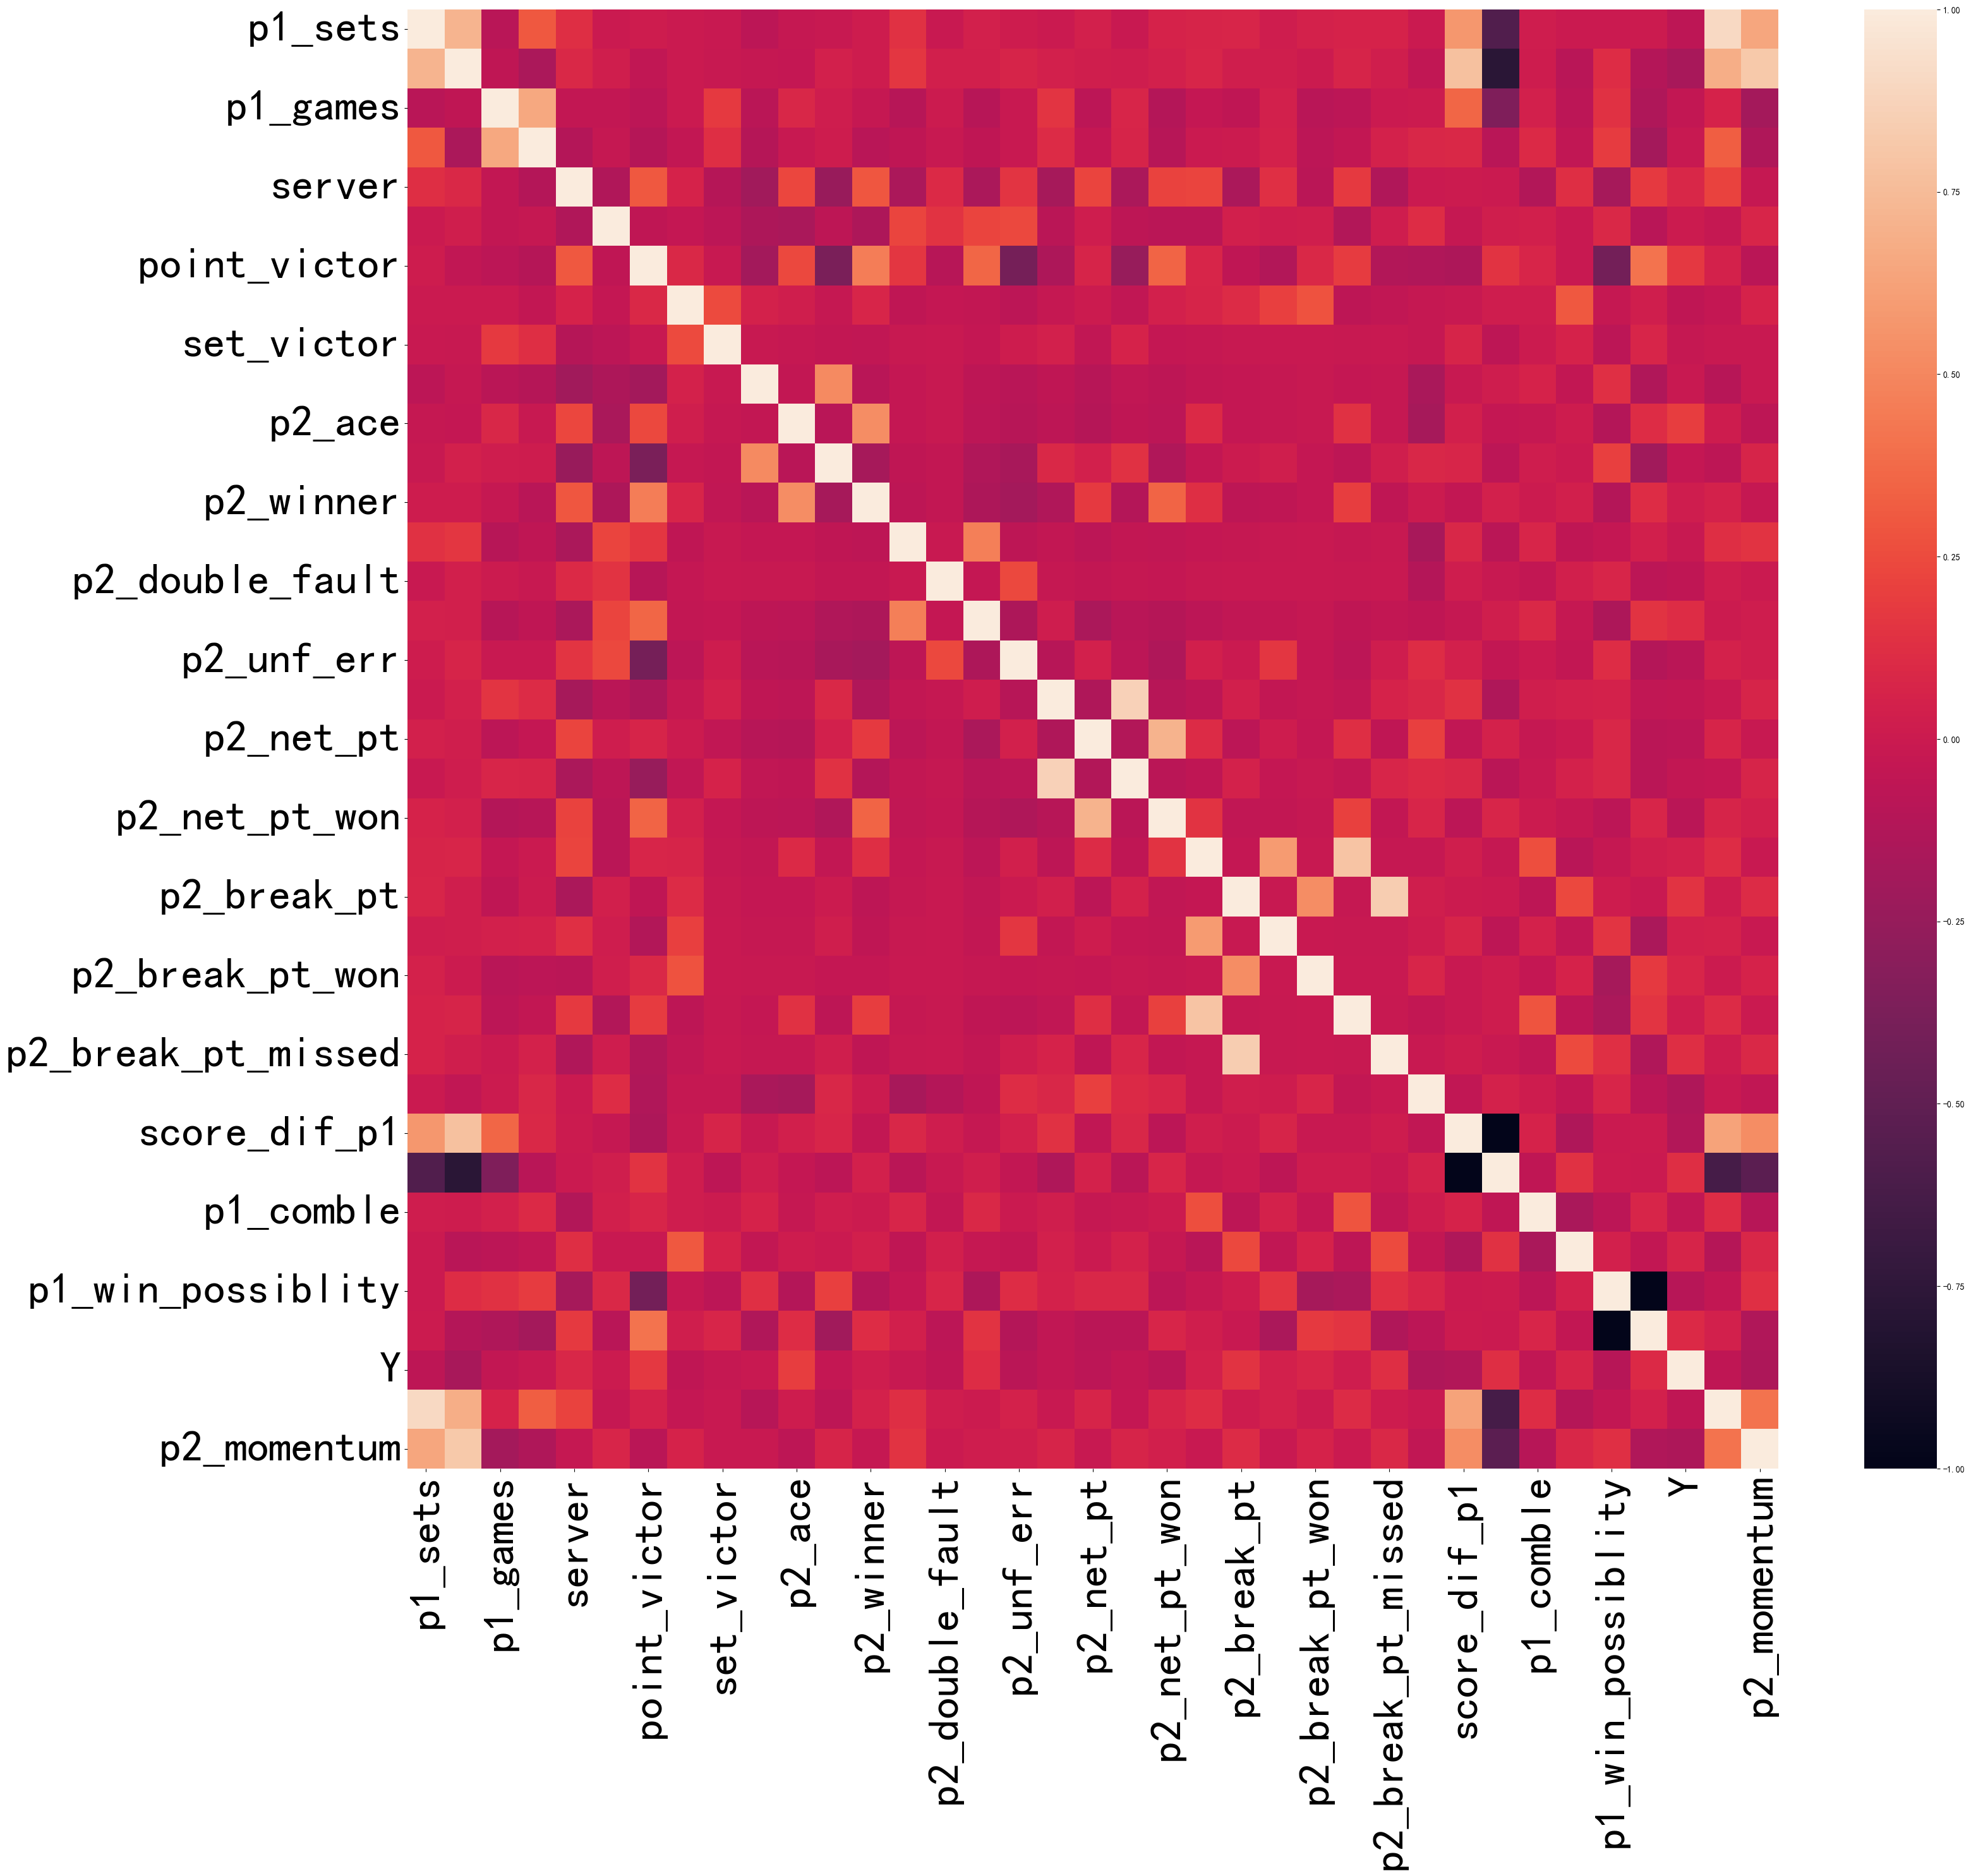

In [430]:

plt.figure(figsize=(35,30))
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
sns.heatmap(heatdf.corr())

In [431]:
# 数据集
def get_ds(df:pd.DataFrame):
    x = []# 特征数据
    print({i:j for i,j in enumerate(df.columns)})
    for index in df.index.values:
        x.append(df.loc[index].values)
    x = np.array(x)
    return x
X = get_ds(dataset)
assert len(X) == len(Y) 
## 训练验证集
n = len(Y)
x_train, x_test = X[:-n//8], X[-n//8:]
y_train, y_test = Y[:-n//8], Y[-n//8:]
print(len(x_test[0]))

{0: 'p1_sets', 1: 'p2_sets', 2: 'p1_games', 3: 'p2_games', 4: 'server', 5: 'serve_no', 6: 'point_victor', 7: 'game_victor', 8: 'set_victor', 9: 'p1_ace', 10: 'p2_ace', 11: 'p1_winner', 12: 'p2_winner', 13: 'p1_double_fault', 14: 'p2_double_fault', 15: 'p1_unf_err', 16: 'p2_unf_err', 17: 'p1_net_pt', 18: 'p2_net_pt', 19: 'p1_net_pt_won', 20: 'p2_net_pt_won', 21: 'p1_break_pt', 22: 'p2_break_pt', 23: 'p1_break_pt_won', 24: 'p2_break_pt_won', 25: 'p1_break_pt_missed', 26: 'p2_break_pt_missed', 27: 'rally_count', 28: 'score_dif_p1', 29: 'score_dif_p2', 30: 'p1_comble', 31: 'p2_comble', 32: 'p1_momentum', 33: 'p2_momentum'}
34


In [432]:
# fit
params = {'objective':'multi:softmax',
    'n_estimators': 100, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.1, 'colsample_bytree': 1,
                'subsample': 1, 'reg_alpha': 0.01, 'reg_lambda': 3, 'learning_rate': 0.3}
xgb= XGBClassifier(params)
xgb.fit(x_train, y_train)

c:\Users\Lithium\OneDrive\桌面\preMCM\.env\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

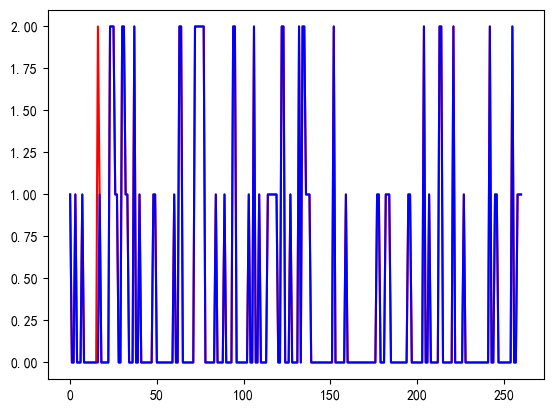

In [433]:
# 检查训练集拟合情况
b, e = 0, -1
y_train_pred = xgb.predict(x_train)
plt.plot(y_train[b:e], color='red')
plt.plot(y_train_pred[b:e], color='blue')

acc: 78.94736842105263%


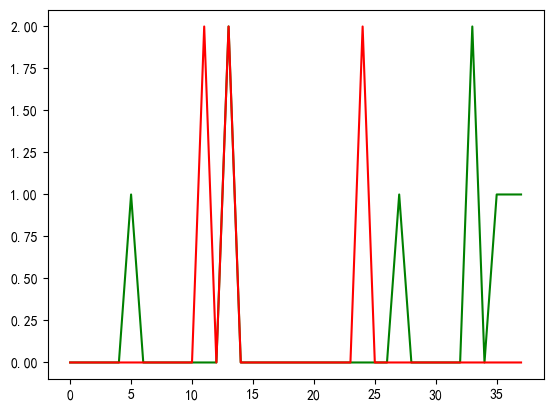

In [434]:
# 验证即拟合情况
y_pred = xgb.predict(x_test)
plt.plot(y_test, color='green')
plt.plot(y_pred, color='red')
# 准确率
acc = 0
for i in range(len(y_pred)):
    if y_pred[i]==y_test[i]:
        acc += 1
print("acc: {}%".format(acc*100/len(y_pred)))

特征重要性: ['score_dif_p1', 'p1_games', 'p2_games', 'rally_count', 'p1_momentum', 'p2_momentum', 'server', 'point_victor', 'serve_no', 'p2_comble', 'p1_sets', 'p2_sets', 'p1_comble', 'game_victor', 'p1_unf_err', 'p1_winner', 'p2_net_pt', 'p2_ace', 'p2_winner', 'p2_unf_err', 'p1_ace', 'p1_net_pt', 'p2_net_pt_won', 'p1_break_pt', 'p2_break_pt', 'p2_break_pt_missed', 'p1_net_pt_won', 'p1_break_pt_won', 'p1_double_fault']
特征重要性: [('f28', 593.0), ('f2', 447.0), ('f3', 305.0), ('f27', 290.0), ('f32', 260.0), ('f33', 212.0), ('f4', 116.0), ('f6', 112.0), ('f5', 88.0), ('f31', 75.0), ('f0', 73.0), ('f1', 66.0), ('f30', 61.0), ('f7', 60.0), ('f15', 54.0), ('f11', 53.0), ('f18', 45.0), ('f10', 36.0), ('f12', 36.0), ('f16', 29.0), ('f9', 20.0), ('f17', 11.0), ('f20', 9.0), ('f21', 9.0), ('f22', 7.0), ('f26', 7.0), ('f19', 4.0), ('f23', 3.0), ('f13', 1.0)]


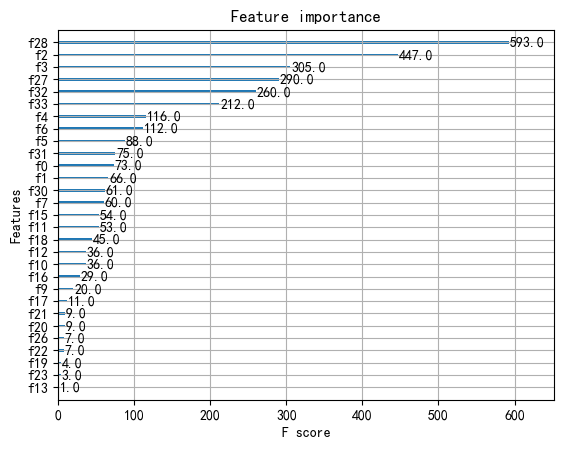

In [435]:
# 重要特征
dic = {'f{}'.format(i):j for i,j in enumerate(dataset.columns)}
def feature_importance_selected(clf_model):
    """模型特征重要性提取与保存"""
    # 模型特征重要性打印和保存
    feature_importance = clf_model.get_booster().get_fscore()
    feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

    print('特征重要性:', [dic.get(i[0], i[0]) for i in feature_importance])
    print('特征重要性:', feature_importance)

    # 模型特征重要性绘图
    plot_importance(xgb)
    plt.show()

feature_importance_selected(xgb)

In [436]:

from sklearn.metrics import precision_score, recall_score,roc_curve
def metrics_sklearn(y_valid, y_pred_):
    """模型对验证集和测试集结果的评分"""
    # 准确率
    accuracy = accuracy_score(y_valid, y_pred_)
    print('Accuracy：%.2f%%' % (accuracy * 100))

    # 精准率
    precision = precision_score(y_valid, y_pred_, average='micro')
    print('Precision：%.2f%%' % (precision * 100))

    # 召回率
    recall = recall_score(y_valid, y_pred_, average='micro')
    print('Recall：%.2f%%' % (recall * 100))

    # F1值
    f1 = f1_score(y_valid, y_pred_, average='micro')
    print('F1：%.2f%%' % (f1 * 100))

    # auc曲线下面积
    # auc = roc_auc_score(y_valid, y_pred_, average='micro')
    # print('AUC：%.2f%%' % (auc * 100))

    # ks值
    # fpr, tpr, thresholds = roc_curve(y_valid, y_pred_, average='micro')
    # ks = max(abs(fpr - tpr))
    # print('KS：%.2f%%' % (ks * 100))
metrics_sklearn(y_test, y_pred)

Accuracy：78.95%
Precision：78.95%
Recall：78.95%
F1：78.95%


### 用xgboost预测转折点

In [437]:
# # 获得转折点
# y_valid = 
# # 获取动量
# p1_momentum = momentum()
# p2_momentum = momentum()
# # xgb预测
# xgb.predict()
# # 画图
